# X Account and Post Data Analysis
**Objective:** Analyze engagment metrics and identify trends.

This notebook is an exploration of X user and post data using pandas, numpy, and matplotlib to generate useful insights.

CSVs in current directory:  
- <b>overview_4M.csv</b> - 4 weeks of account-related data such as Likes, New follows, and Profile visits  
- <b>posts_4M.csv</b> - 4 weeks of post-related data such as Post Id, Post text, and Engagements  

# Setup

### Environment

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
plt.style.use('dark_background')
plt.rcParams["legend.labelcolor"] = "white"

### Load data

In [3]:
overview = pd.read_csv('overview_4W.csv')
posts = pd.read_csv('posts_4W.csv')

# Clean data

### Format dates

In [4]:
# %a - abbreviated weekday name ('Mon')
# %b - abbreviated month name ('Feb')
# %d - day of the month ('25')
# %Y - four digit year (2025)

overview['Date'] = pd.to_datetime(overview['Date'], format='%a, %b %d, %Y')
posts['Date'] = pd.to_datetime(posts['Date'], format='%a %b %d %Y')

### Drop unused columns

In [5]:
unused_columns_overview = ['Video views', 'Media views']
unused_columns_post = ['Post id', 'Link', 'Hashtag clicks', 'Permalink clicks']
posts = posts.drop(unused_columns_post, axis=1)
overview = overview.drop(unused_columns_overview, axis=1)

### Merge dataframes

In [6]:
x_data = overview.merge(posts, how='left', on='Date', suffixes=['_o', '_p'])

### Convert values to snake case

In [7]:
def snake_case(text):
    snake_cased = []
    for i, char in enumerate(text):
        if char.isupper():
            if snake_cased and snake_cased[-1] != '_': 
                snake_cased.append('_')
            snake_cased.append(char.lower())
        elif char == ' ':
            if snake_cased and snake_cased[-1] != '_':
                snake_cased.append('_')
        else:
            snake_cased.append(char)
    
    return ''.join(snake_cased)

sample_name = 'Cool Metric'    
print(f'{sample_name} is converted to {snake_case('Cool Metric')}')

Cool Metric is converted to cool_metric


### Convert column names to snake case

In [8]:
x_data.columns = [snake_case(col) for col in x_data.columns]

# convert floats back to int after merge
affected_columns = ['impressions_p', 'likes_p', 'engagements_p', 'bookmarks_p', 'share', 'new_follows_p', 'replies_p', 'reposts_p', 'profile_visits_p', 'detail_expands']

for col in affected_columns:
    x_data[col] = x_data[col].fillna(0).astype(int)

# Add features

### Datetime helper values

In [9]:
x_data['month'] = pd.Categorical(
    x_data['date'].dt.strftime('%b'),
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

x_data['week_number'] = (x_data['date'] - x_data['date'].min()).dt.days // 7 + 1

x_data['weekday'] = pd.Categorical(
    x_data['date'].dt.strftime('%a'),
    categories=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    ordered=True
)

# reverse row order
# merged = merged[::-1]

### Net follower change

In [10]:
x_data['net_follower_change'] = x_data['new_follows_o'] - x_data['unfollows']

# Exploratory Data Analysis

In [11]:
x_data.head()

,date,impressions_o,likes_o,engagements_o,bookmarks_o,shares,new_follows_o,unfollows,replies_o,reposts_o,profile_visits_o,create_post,post_text,impressions_p,likes_p,engagements_p,bookmarks_p,share,new_follows_p,replies_p,reposts_p,profile_visits_p,detail_expands,url_clicks,month,week_number,weekday,net_follower_change
0,2025-02-27,142,1,5,0,0,1,0,1,0,0,0,@davidcafor SwiftData pushed me towards writin...,24,0,1,0,0,0,1,0,0,0,0.0,Feb,4,Thu,1
1,2025-02-26,273,1,3,0,0,1,0,1,0,0,0,@nickfloats i use chatgpt to reverse engineer ...,53,0,0,0,0,0,0,0,0,0,0.0,Feb,4,Wed,1
2,2025-02-25,1627,7,22,1,0,0,0,1,0,5,2,@ziademarcus why is this the best mle resource...,13,2,3,0,0,0,1,0,0,0,0.0,Feb,4,Tue,0
3,2025-02-25,1627,7,22,1,0,0,0,1,0,5,2,@mnowakdesign you’re bananas.,15,0,0,0,0,0,0,0,0,0,0.0,Feb,4,Tue,0
4,2025-02-25,1627,7,22,1,0,0,0,1,0,5,2,this is bananas,286,2,12,0,0,0,1,0,4,5,0.0,Feb,4,Tue,0


## Overview

### Engagement

In [12]:
impressions = x_data['impressions_o']
engagements = x_data['engagements_o']

total_impressions = impressions.sum()
total_engagements = engagements.sum()

engagement_rate = round((total_engagements / total_impressions * 100), 1)
print(f'Impressions: {total_impressions}')
print(f'Engagements: {total_engagements}')
print(f'Engagement rate: {engagement_rate}%')

Impressions: 1313695
Engagements: 43163
Engagement rate: 3.3%


### Average Daily Engagement

In [13]:
avg_daily_engagement = (engagements / impressions).mean() * 100
print(f'Average daily engagment: {avg_daily_engagement.round(1)}')

Average daily engagment: 3.1


### Profile Visits

In [14]:
profile_visits = x_data.groupby('date').first()['profile_visits_o'].sum()
print(f'Profile Visits: {profile_visits}')

Profile Visits: 456


In [15]:
avg_daily_visits = round((profile_visits / 28), 1)
print(f'Average Daily Profile Vists: {avg_daily_visits}')

Average Daily Profile Vists: 16.3


### Daily Follower Count Changs

In [16]:
net_follower_change = x_data['net_follower_change']

print(f'Net follower change: {net_follower_change.sum()}')
print(f'Largest follower increase: {net_follower_change.max()}')
print(f'Largest follower decrease: {net_follower_change.min()}')
print(f'Average daily change: {net_follower_change.mean().round(2)}')

Net follower change: 1338
Largest follower increase: 83
Largest follower decrease: -5
Average daily change: 15.38


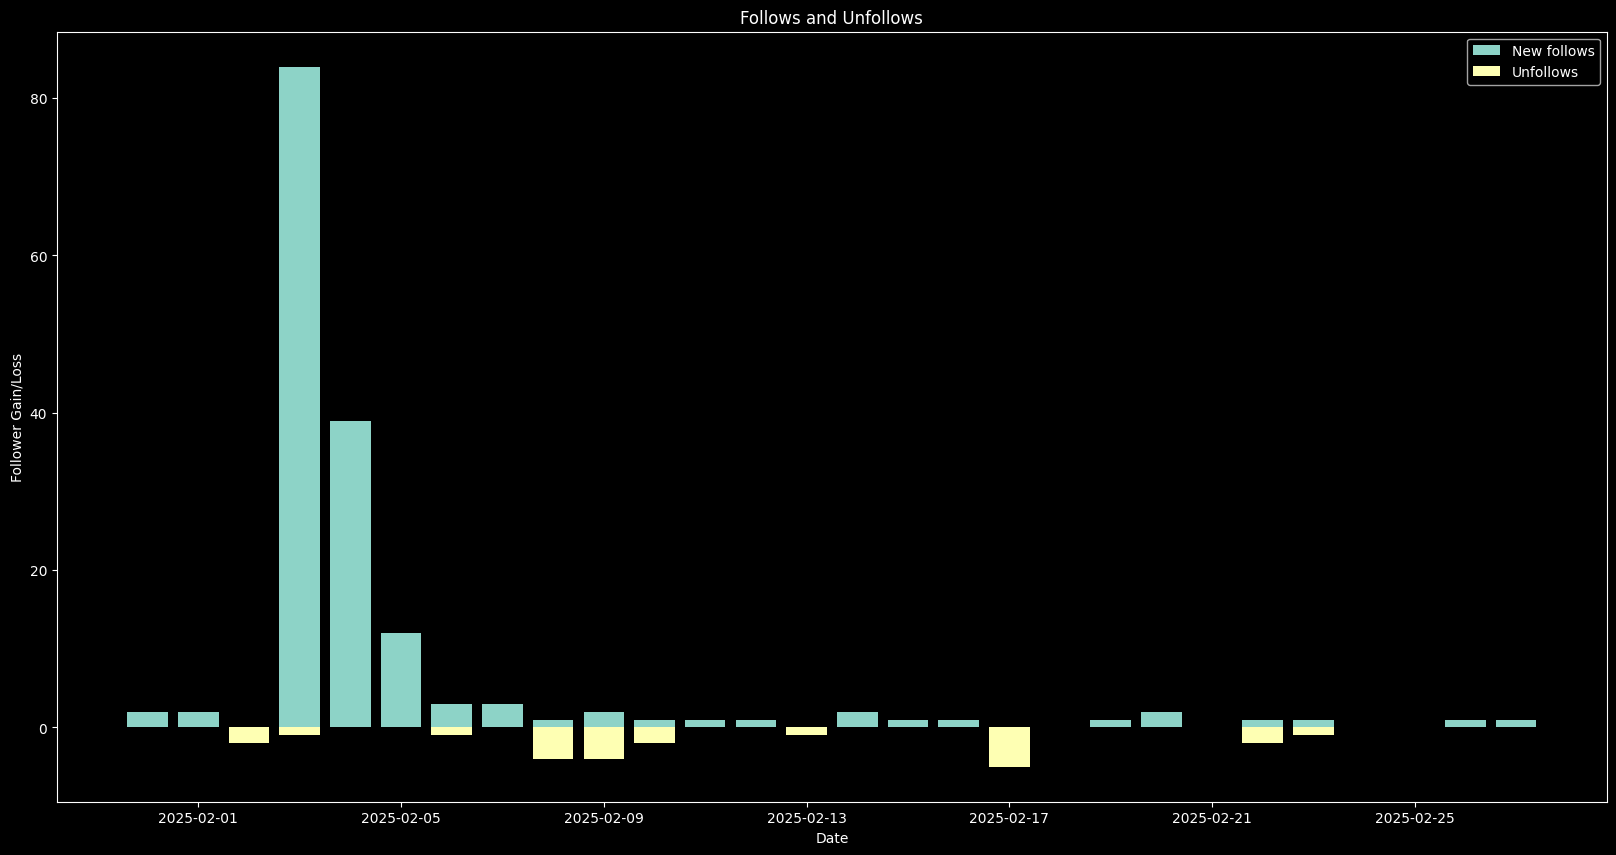

In [17]:
# Remove outliers
# outliers = np.partition(x_data['new_follows_o'].values, -4)[-4:]
# x_data = x_data[~x_data['new_follows_o'].isin(outliers)]

x = x_data['date']
y_follows = x_data['new_follows_o']
y_unfollows = (-x_data['unfollows'])

plt.figure(figsize=(20, 10))

plt.bar(x, y_follows, label='New follows')
plt.bar(x, y_unfollows, label='Unfollows')

plt.title('Follows and Unfollows')
plt.xlabel('Date')

plt.ylabel('Follower Gain/Loss')
plt.grid(False)
plt.legend()
plt.show()

## Posts

### Post Activity

In [29]:
total_posts = x_data['post_text'].count()
daily_average = round((total_posts / 28))
print(f'''
{total_posts} posts over the past 4 weeks, averaging ~{daily_average} posts daily.
''')


82 posts over the past 4 weeks, averaging ~3 posts daily.



### Post Activity by Day

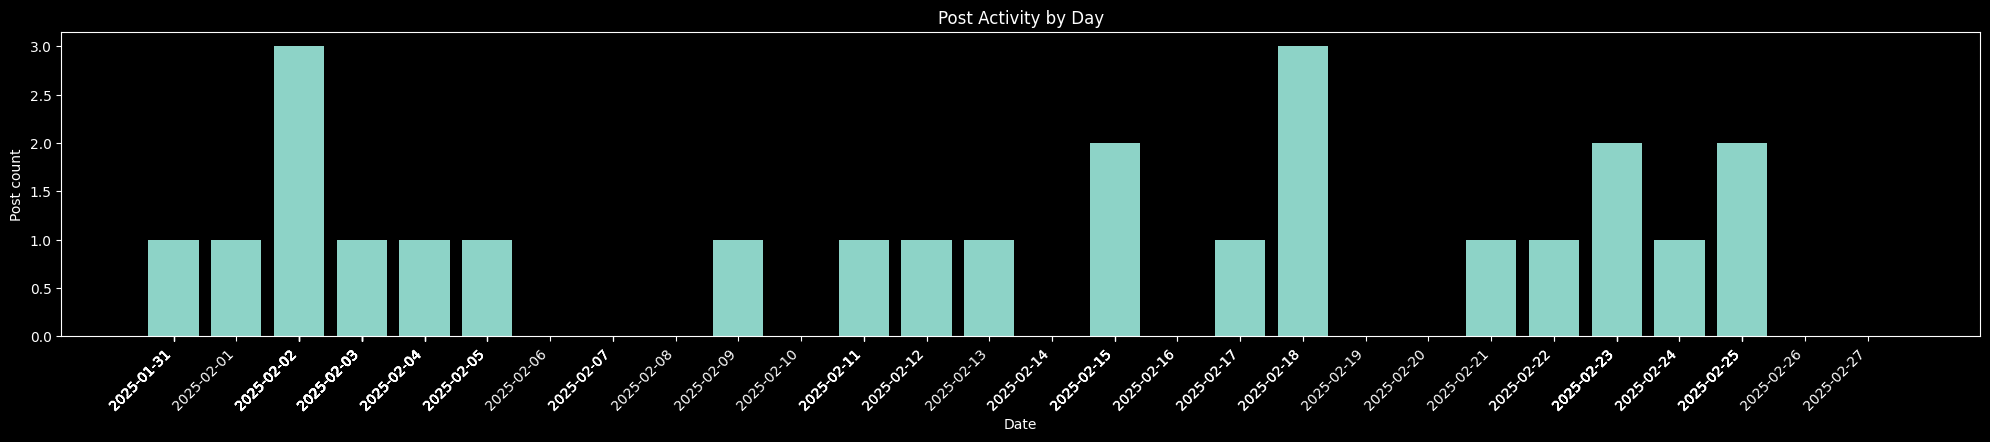

In [19]:
create_post_by_day = x_data.groupby('date').first()['create_post']
plt.figure(figsize=(20,4))
plt.title('Post Activity by Day')
plt.xlabel('Date')
plt.ylabel('Post count')
plt.bar(create_post_by_day.index, create_post_by_day.values, label='Create post')
plt.tight_layout()

plt.xticks(x[::1], rotation=45, ha='right')
plt.grid(False)
plt.show()

### Engagement Details

In [30]:
replies = x_data['replies_p'].sum()
likes = x_data['likes_p'].sum()
reposts = x_data['reposts_p'].sum()
bookmarks = x_data['bookmarks_p'].sum()
shares = x_data['shares'].sum()

print(f'''
Replies: {replies}
Likes: {likes}
Reposts: {reposts}
Bookmarks: {bookmarks}
Shares: {shares}
''')


Replies: 47
Likes: 1377
Reposts: 58
Bookmarks: 792
Shares: 228



### Replies posted

In [31]:
replies = x_data['post_text'].str.startswith('@').sum()
total_posts = len(posts)
reply_rate = round((replies / total_posts * 100), 2)
print(f'''
Replies account for {reply_rate}% of all posts
''')


Replies account for 62.2% of all posts



### Replies by recipient

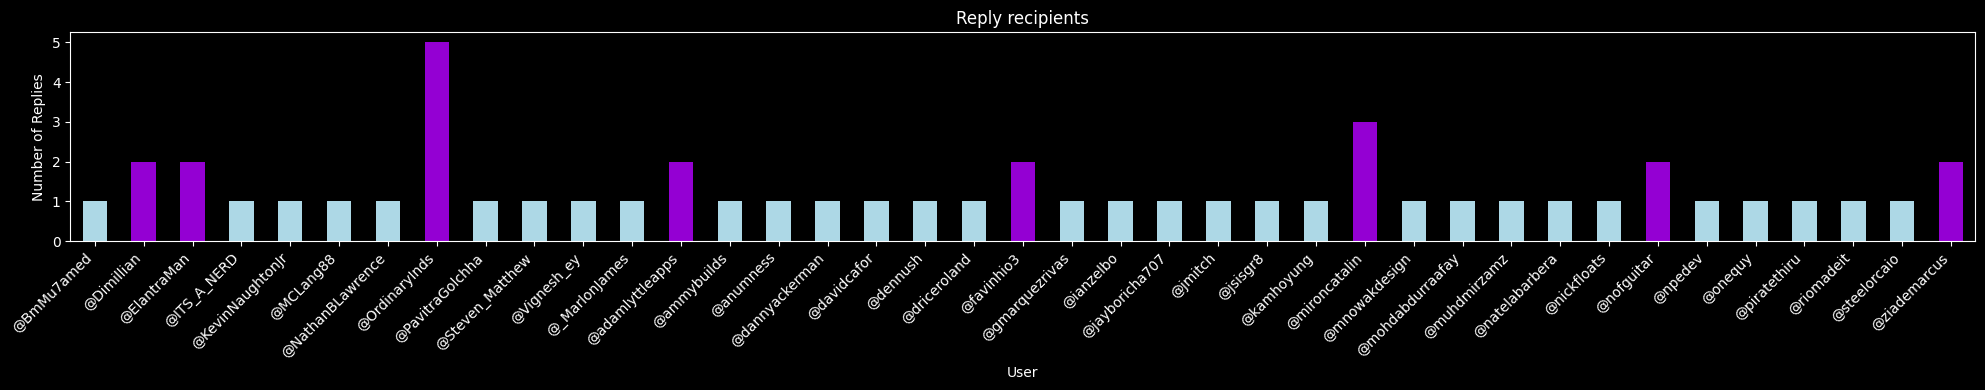

In [22]:
replies_df = posts[posts['Post text'].str.startswith('@')]
grouped_replies = replies_df.groupby(posts['Post text'].str.split().str[0]).size()
most_replied = grouped_replies.idxmax()

plt.figure(figsize=(20, 4))

threshold = 2
colors = ['darkviolet' if count >= threshold else 'lightblue' for count in grouped_replies]

grouped_replies.plot(kind='bar', color=colors)

plt.xlabel('User')
plt.ylabel('Number of Replies')
plt.title('Reply recipients')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.grid(False)
plt.show()

### Posts by Weekday

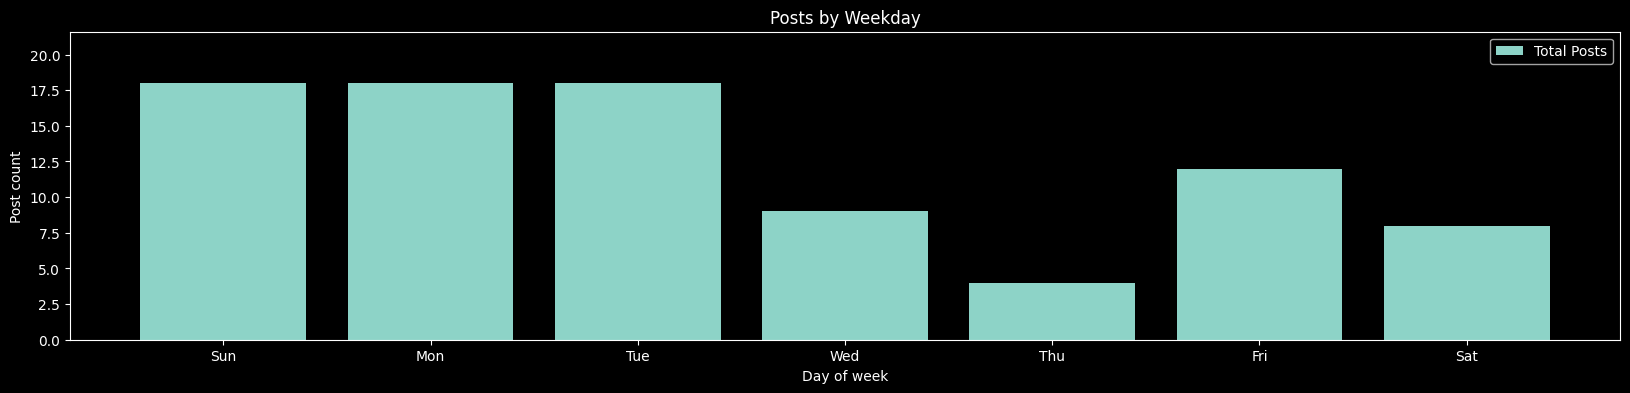

In [23]:
posts_by_weekday = x_data.groupby('weekday', observed=True).size()

plt.figure(figsize=(20, 4))
plt.bar(posts_by_weekday.index, posts_by_weekday.values, label='Total Posts')

plt.xlabel('Day of week')
plt.ylabel('Post count')
plt.title('Posts by Weekday')

plt.ylim(0, (posts_by_weekday.max() * 1.2))  # 20% buffer for headroom

plt.legend()
plt.grid(False)
plt.show()

In [33]:
top_post = posts[posts['Likes'] == posts['Likes'].max()]
most_liked_post_text = top_post['Post text'].iloc[0]

top_post_text = top_post['Post text'].iloc[0]

likes = top_post['Likes'].iloc[0]
impressions =  top_post['Impressions'].iloc[0]
engagements =  top_post['Engagements'].iloc[0]
bookmarks =  top_post['Bookmarks'].iloc[0]
shares =  top_post['Share'].iloc[0]

print(f'''
Most Liked Post:

{most_liked_post_text}

Likes: {likes}'
Impressions: {impressions}')
Engagements: {engagements}')
Bookmarks: {bookmarks}')
Shares: {shares}
''')


Most Liked Post:

decided it’s time to learn app intents. rigged up a simple use case with two intents, and exposed them to the system as a shortcut. code in replies ⬇️ https://t.co/jxXGOPH18r

Likes: 943'
Impressions: 89208')
Engagements: 2922')
Bookmarks: 622')
Shares: 20



### Top Post Metrics

### Bookmarks

In [25]:
total_bookmarks = x_data.groupby('date').first()['bookmarks_o'].sum()

print(f'''
Users bookmarked your posts {total_bookmarks} times.
''')

Users bookmarked your posts 805 times


### Profile Visits

In [34]:
total_profile_visits = x_data.groupby('date').first()['profile_visits_o'].sum()

print(f'''
{total_profile_visits} visits made to your profile.
''')


456 visits made to your profile.



### Likes

In [35]:
total_likes = x_data.groupby('post_text').first()['likes_p'].sum()
avg_likes = round(total_likes / len(posts))

print(f'''
Your posts received an average of {avg_likes} likes.
''')


Your posts received an average of 17 likes.



### Most Verbose Post

In [36]:
op_posts = posts.copy()
op_posts = op_posts[~op_posts['Post text'].str.startswith('@')]
op_posts['word_count'] = op_posts['Post text'].str.split().str.len()

max = op_posts['word_count'].max()
most_verbose_post = op_posts[op_posts['word_count'] == max]['Post text'].values[0]

print(f'''
Most verbose post of the last 90 days: \n\n{most_verbose_post}\n
Word count: {max}
''')


Most verbose post of the last 90 days: 

3 weeks ago I was reminded about @SunoMusic and learned just how impressive V4 outputs are. realized the opportunity to start releasing music under various artist names, across several genres. today, it all begins. stream “Origin I” by One Zero wherever you listen 🎧 https://t.co/DnFiulVTnw

Word count: 45

